# Data Science with Neo4j Using Yelp Data

### Module 2: Segmentation and Community Detection (Work in Progress)

Goal: Find communities based on categories of restaurants users review      

Algorithm: Label Propagation

High Level Approach:
      
- Subset data to only include restaurants in Toronto.  Consequently, this means we are only considering users who reviewed restaurants in Toronto.
- Population:  66,639 users, 2963 businesses, 94 categories
- Relationships: user REVIEWED business, business IN_CATEGORY, user REVIEWED_CATEGORY
- Create weights between users to form tighter communities (jaccard index between users based on # restaurant categories)
- Draw parallels with traditional data science clustering approaches (eg: k-means, kNN)

In [2]:
from neo4j.v1 import GraphDatabase, basic_auth
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
uri  = os.getenv('NEO4J_URI',  'bolt://localhost:7687')
user = os.getenv('NEO4J_USER', 'neo4j')
pwd  = os.getenv('NEO4J_PWD',  'neo4j')

driver = GraphDatabase.driver(uri, auth=basic_auth(user, pwd))

#### Part 1: Compute Jaccard index between user pairs

In [3]:
%%time

# first, create relationship between users and categories.
query = """
        MATCH (u:User)-[:REVIEWED]->(b:Business)-[:IN_CATEGORY]->(c:Category)
        WITH u, c, COUNT(DISTINCT b) as num_business
        CREATE (u)-[:REVIEWED_CATEGORY {num_reviewed: num_business}]->(c)        
        """     

with driver.session() as session:
    result = session.run(query)

CPU times: user 2.28 ms, sys: 2.39 ms, total: 4.67 ms
Wall time: 9.47 s


In [3]:
%%time

# count number of REVIEWED_CATEGORY relationships
query = """
        MATCH ()-[r:REVIEWED_CATEGORY]->()
        RETURN COUNT(r)
        """     

with driver.session() as session:
    result = session.run(query)
    
result_df = [dict(record) for record in result]
display(result_df)

[{'COUNT(r)': 474179}]

CPU times: user 4.74 ms, sys: 2.5 ms, total: 7.24 ms
Wall time: 26.1 ms


In [4]:
%%time

# get distribution of number of categories reviewed by user
query = """
        MATCH (u:User)-[r:REVIEWED_CATEGORY]->()
        RETURN u.id as id, COUNT(r) as num_category_reviewed
        """     

with driver.session() as session:
    result = session.run(query)
    
result_df = pd.DataFrame([dict(record) for record in result])
display(result_df.head())

,id,num_category_reviewed
0,0P_wUAKVI8HfKxb4OAHOHA,3
1,X_7WEtz0cPkUBFSGjRz9pg,14
2,vrDr2a7ECpZOHlPGY7tnUA,6
3,XpykVM_2W9LWPyP1S8wu4A,1
4,w0WY5LJVTdAXjpWKJJPbnQ,6


CPU times: user 2.7 s, sys: 55.3 ms, total: 2.75 s
Wall time: 3.39 s


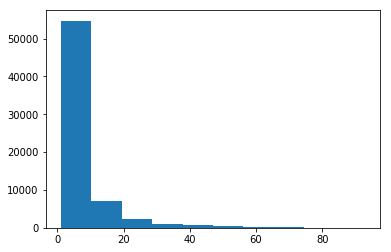

,num_category_reviewed
count,66639.000000
mean,7.115638
std,8.827368
min,1.000000
10%,1.000000
15%,2.000000
20%,2.000000
25%,2.000000
50%,4.000000
60%,5.000000


In [5]:
plt.hist(result_df['num_category_reviewed'])
plt.show()     
display(result_df.describe(percentiles=[0.1,0.15,0.2,0.25,0.5,0.6,0.75,0.8,0.9,0.95,0.99]))


In [6]:
result_df[result_df.num_category_reviewed >= 3].shape

(47535, 2)

In [7]:
%%time

# compute intersection, union and jaccard index and store the index in the graph
query = """
        MATCH ()-[s:SIMILAR_TO]->()
        DELETE s
        """     

with driver.session() as session:
    result = session.run(query)

CPU times: user 1.51 ms, sys: 1.78 ms, total: 3.29 ms
Wall time: 128 ms


In [8]:
%%time

# compute intersection, union and jaccard index and store the index in the graph
# only do for user pairs who have reviewed at least 5 businesses in a category
query = """
        MATCH (u1:User)-[r1:REVIEWED_CATEGORY]->(c:Category)<-[r2:REVIEWED_CATEGORY]-(u2:User)
        WHERE r1.num_reviewed >= 5
          AND r2.num_reviewed >= 5
          AND id(u1) < id(u2) 
        WITH  u1, u2, COUNT(DISTINCT c) as intersection_count, 
                SIZE((u1)-[:REVIEWED_CATEGORY]->()) as cat1,
                SIZE((u2)-[:REVIEWED_CATEGORY]->()) as cat2
        WITH  u1, u2, (intersection_count * 1.0) / (cat1 + cat2 - intersection_count) as jaccard_index
        CREATE (u1)-[:SIMILAR_TO {similarity: jaccard_index}]->(u2)
        """     

with driver.session() as session:
    result = session.run(query)

CPU times: user 8.38 ms, sys: 6.07 ms, total: 14.5 ms
Wall time: 2min 30s


In [9]:
%%time

query = """
        MATCH (u:User)-[r:SIMILAR_TO]->()
        RETURN COUNT(DISTINCT u)       
        """     

with driver.session() as session:
    result = session.run(query)
    
result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.head())

,COUNT(DISTINCT u)
0,3283


CPU times: user 9.6 ms, sys: 3.25 ms, total: 12.9 ms
Wall time: 1.21 s


In [10]:
%%time

query = """
        MATCH ()-[r:SIMILAR_TO]->()
        RETURN COUNT(r)       
        """     

with driver.session() as session:
    result = session.run(query)

CPU times: user 1.84 ms, sys: 1.99 ms, total: 3.83 ms
Wall time: 579 ms


In [11]:
similarto_df = pd.DataFrame([dict(record) for record in result])
    
display(similarto_df.head())

,COUNT(r)
0,3157255


#### Part 2: Label Propagation

In [ ]:
# users we're considering for label prop

In [4]:
query = """
  MATCH (u:User)-[r:REVIEWED_CATEGORY]->() WHERE r.num_reviewed >= 5 RETURN COUNT(distinct u)
  """

with driver.session() as session:
    result = session.run(query)
    
result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.head())

,COUNT(distinct u)
0,3288


In [16]:
%%time

  # call label prop using jaccard index as weight 
query = """
CALL algo.labelPropagation(
  "MATCH (u:User)-[s:SIMILAR_TO]->() RETURN DISTINCT id(u) as id",
  "MATCH (u1:User)-[s:SIMILAR_TO]->(u2:User) RETURN id(u1) as source, id(u2) as target, s.similarity as weight",
  "OUT",
  {graph:'cypher', iterations:100, partitionProperty:'cluster', weightProperty:'similarity', write: true})
  YIELD nodes, iterations, didConverge, loadMillis, computeMillis, writeMillis, write, partitionProperty;
  """

with driver.session() as session:
    result = session.run(query)
    

CPU times: user 2.3 ms, sys: 2.62 ms, total: 4.91 ms
Wall time: 6.04 s


In [17]:
result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.head(10))

,computeMillis,didConverge,iterations,loadMillis,nodes,partitionProperty,write,writeMillis
0,1412,True,6,4458,3283,cluster,True,7


In [18]:
%%time

query = """
        MATCH (u:User)
        RETURN u.id, u.cluster
        """     

with driver.session() as session:
    result = session.run(query)

CPU times: user 3.29 s, sys: 165 ms, total: 3.46 s
Wall time: 3.88 s


In [19]:
result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.head(10))

,u.cluster,u.id
0,2899999,EDH3SBuXcs8_pTrjSVJDnQ
1,1,FQayGWArjAfBgcvmm07dgw
2,2,9YOzCI_usUjGOCjn2khK4A
3,3,rRxREkOeMghC9OvSj-4KZg
4,4,ZKBJvRqfDGetdTLG4CdlzA
5,5,7VoHyLO1O0BbKb2wHD8bfA
6,6,BoVXPUjo0yc8DCwTpZ0qwQ
7,7,NOYCoDc5-hQiWrLpYC_9gw
8,8,op2yH1xpItKK4VqigfnuOA
9,9,KxRgu76i_tWQKFZB1cIjww


In [20]:
x = pd.DataFrame(result_df.groupby('u.cluster')['u.id'].count()).reset_index()

In [21]:
x.head()

,u.cluster,u.id
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [22]:
x[x['u.id'] > 1] 

,u.cluster,u.id
411,433,3283


In [12]:
x['u.id'].sum()

66639